# NYC Property Sales Analysis Project

## Task
Analyze the NYC property sales data from "nyc-property-sales.csv" by loading, cleaning, and preprocessing it, including filtering for the last 10 years and addressing $0 sales prices. Perform a comprehensive Exploratory Data Analysis (EDA) on numerical and categorical features, including time series analysis and correlation. Engineer new features, then train and evaluate a Linear Regression model and a Gradient Boosting Regressor model to predict sales prices. Finally, compare the performance of both models, analyze feature importances, and provide a comprehensive conclusion with key findings, insights, and recommendations regarding the NYC property sales market.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
import matplotlib.ticker as mtick
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data and Initial Overview


In [ ]:
# Load the dataset, setting low_memory=False to handle mixed types and suppress DtypeWarning
df = pd.read_csv('/content/drive/MyDrive/nyc-property-sales.csv', low_memory=False)

# Get an initial overview of the number of rows and columns
print(f"\nDataFrame shape: {df.shape[0]} rows, {df.shape[1]} columns")


DataFrame shape: 1404049 rows, 21 columns


## Filter Data for Last 5 Years

In [ ]:
# 1. Convert 'SALE DATE' to datetime objects, coercing errors
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], errors='coerce')

# 2. Find the maximum date in the 'SALE DATE' column
most_recent_date = df['SALE DATE'].max()
print(f"Most recent sale date: {most_recent_date}")

# 3. Calculate the date 5 years prior to the most recent sale date
five_years_ago = most_recent_date - pd.DateOffset(years=5)
print(f"Date 5 years prior to most recent sale: {five_years_ago}")

# 4. Filter the DataFrame for sales records from the last 6 years
df_filtered = df[df['SALE DATE'] >= five_years_ago].copy()

# 5. Display the shape of the filtered DataFrame
print(f"\nShape of DataFrame after filtering for last 5 years: {df_filtered.shape}")

Most recent sale date: 2022-12-31 00:00:00
Date 5 years prior to most recent sale: 2017-12-31 00:00:00

Shape of DataFrame after filtering for last 5 years: (428248, 21)


## Data Cleaning and Preprocessing

In [ ]:
# Make a copy to avoid SettingWithCopyWarning
df_cleaned = df_filtered.copy()

# --- Strip whitespace from column names first ---
df_cleaned.columns = df_cleaned.columns.str.strip()
print("Stripped whitespace from column names.")
# -----------------------------------------------------

# 1. Identify and clean non-numeric characters from columns that should be numeric
# and 2. Convert the identified columns to appropriate numeric data types
numeric_cols = [
    'BOROUGH', 'BLOCK', 'LOT', 'ZIP CODE', 'RESIDENTIAL UNITS',
    'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET',
    'GROSS SQUARE FEET', 'YEAR BUILT', 'SALE PRICE'
]

for col in numeric_cols:
    # Some numeric columns might contain non-numeric characters like commas or spaces
    # Replace them before converting to numeric
    if col in df_cleaned.columns and df_cleaned[col].dtype == 'object': # Check if column exists and is object type
        df_cleaned[col] = df_cleaned[col].astype(str).str.replace(',', '', regex=False)
        df_cleaned[col] = df_cleaned[col].astype(str).str.replace(' ', '', regex=False)

    # Convert to numeric, coercing errors to NaN
    # Also ensure the column exists before attempting conversion
    if col in df_cleaned.columns:
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

# 3. Drop rows where 'SALE DATE' is NaT
initial_rows = df_cleaned.shape[0]
df_cleaned.dropna(subset=['SALE DATE'], inplace=True)
print(f"Dropped {initial_rows - df_cleaned.shape[0]} rows with NaT in 'SALE DATE'. Remaining rows: {df_cleaned.shape[0]}")

# 4. Remove rows where 'SALE PRICE' is 0
initial_rows = df_cleaned.shape[0]
df_cleaned = df_cleaned[df_cleaned['SALE PRICE'] != 0].copy()
print(f"Dropped {initial_rows - df_cleaned.shape[0]} rows where 'SALE PRICE' was 0. Remaining rows: {df_cleaned.shape[0]}")

# 5. Drop the 'EASE-MENT' column
if 'EASE-MENT' in df_cleaned.columns:
    df_cleaned.drop(columns=['EASE-MENT'], inplace=True)
    print("Dropped 'EASE-MENT' column.")
else:
    print("'EASE-MENT' column not found or already dropped.")

# 6. Drop any remaining rows that have NaN values in critical numerical columns
critical_numeric_cols = [
    'SALE PRICE', 'GROSS SQUARE FEET', 'LAND SQUARE FEET',
    'YEAR BUILT', 'TOTAL UNITS'
]

initial_rows = df_cleaned.shape[0]
df_cleaned.dropna(subset=critical_numeric_cols, inplace=True)
print(f"Dropped {initial_rows - df_cleaned.shape[0]} rows with NaN in critical numerical columns. Remaining rows: {df_cleaned.shape[0]}")

print("\nDataFrame Info after cleaning:")
df_cleaned.info()

print("\nFirst 5 rows of the cleaned DataFrame:")
print(df_cleaned.head())

Stripped whitespace from column names.
Dropped 0 rows with NaT in 'SALE DATE'. Remaining rows: 428248
Dropped 127650 rows where 'SALE PRICE' was 0. Remaining rows: 300598
Dropped 'EASE-MENT' column.
Dropped 110597 rows with NaN in critical numerical columns. Remaining rows: 190001

DataFrame Info after cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 190001 entries, 0 to 515807
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   BOROUGH                         190001 non-null  int64         
 1   NEIGHBORHOOD                    190001 non-null  object        
 2   BUILDING CLASS CATEGORY         190001 non-null  object        
 3   TAX CLASS AT PRESENT            190001 non-null  object        
 4   BLOCK                           190001 non-null  int64         
 5   LOT                             190001 non-null  int64         
 6   BUILDING CLASS AT PRESE

## Exploratory Data Analysis

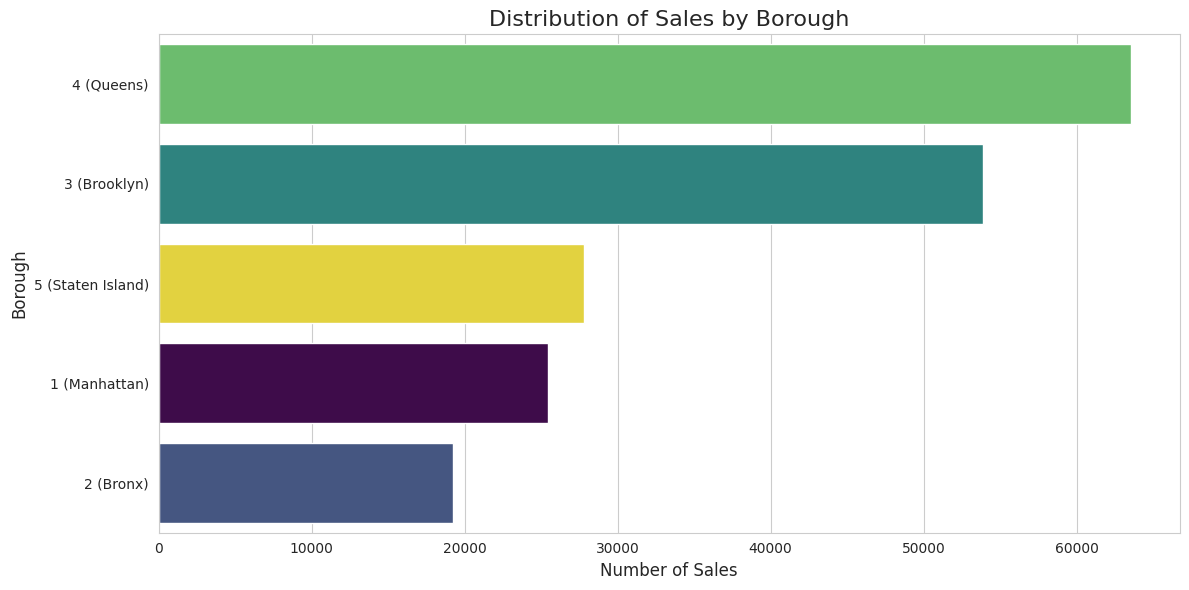

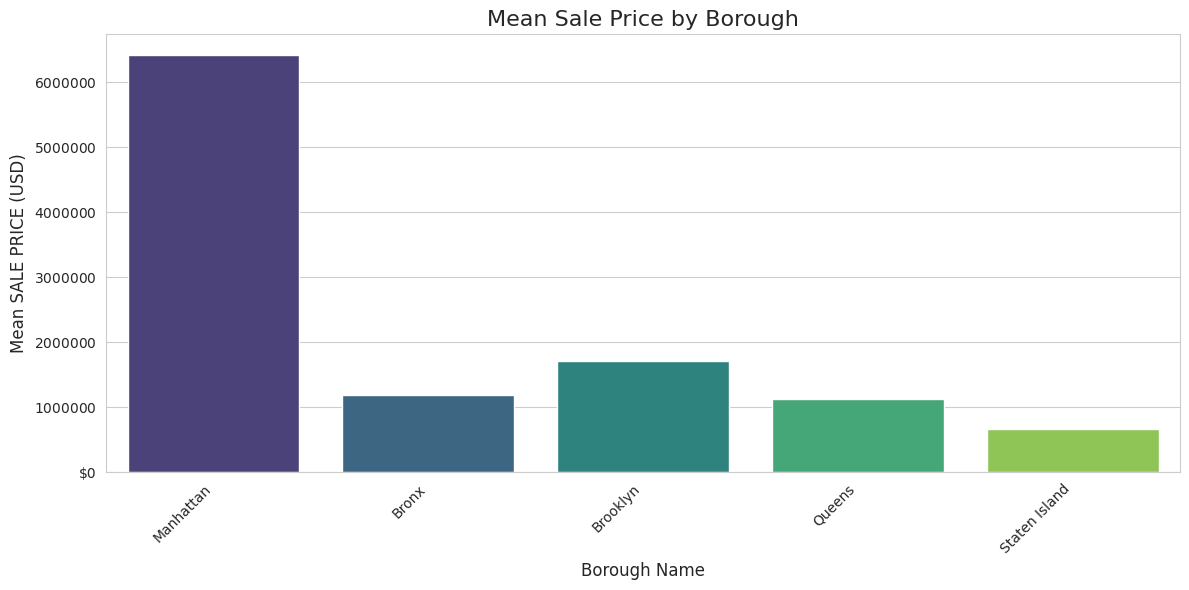

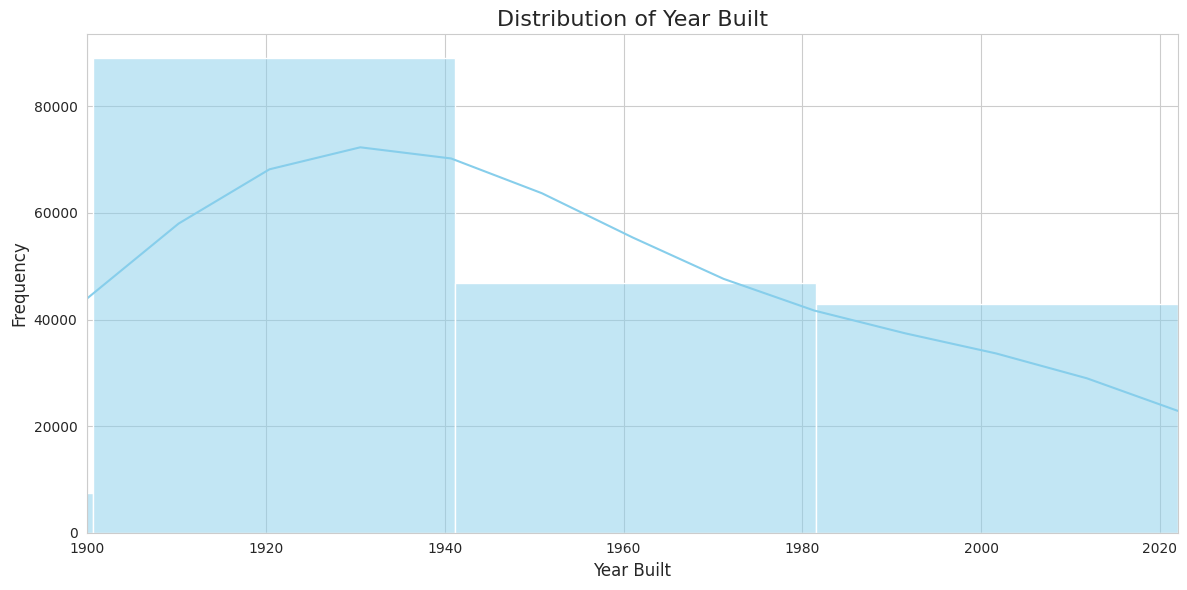

In [ ]:
# Define a mapping for borough numbers to names
borough_names = {
    1: 'Manhattan',
    2: 'Bronx',
    3: 'Brooklyn',
    4: 'Queens',
    5: 'Staten Island'
}

# Get the ordered borough values
ordered_boroughs = df_cleaned['BOROUGH'].value_counts().index

# Create custom y-axis labels with numbers and names
custom_labels = [f"{num} ({borough_names.get(num, 'Unknown')})" for num in ordered_boroughs]

# Set up the plotting style
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.countplot(data=df_cleaned, y='BOROUGH', order=ordered_boroughs, palette='viridis', hue='BOROUGH', legend=False)
plt.title('Distribution of Sales by Borough', fontsize=16)
plt.xlabel('Number of Sales', fontsize=12)
plt.ylabel('Borough', fontsize=12)

# Set the custom y-axis tick labels
plt.yticks(ticks=range(len(ordered_boroughs)), labels=custom_labels)

plt.tight_layout()
plt.show()


# Create BOROUGH_NAME column for plotting
df_cleaned['BOROUGH_NAME'] = df_cleaned['BOROUGH'].map(borough_names)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_cleaned, x='BOROUGH_NAME', y='SALE PRICE', palette='viridis', hue='BOROUGH_NAME', legend=False, errorbar=None)
plt.title('Mean Sale Price by Borough', fontsize=16)
plt.xlabel('Borough Name', fontsize=12)
plt.ylabel('Mean SALE PRICE (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add currency formatting to the y-axis ticks for better clarity
fmt = mtick.FormatStrFormatter('$%1.0f') # Format as dollar, no decimal places
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',d').replace(',', '$') if x > 0 else '$0')) # Custom formatter for better readability of large numbers

df_cleaned.drop(columns=['BOROUGH_NAME'], inplace=True)

plt.tight_layout()
plt.show()

# Get the latest year from the 'YEAR BUILT' column
latest_year = df_cleaned['YEAR BUILT'].max()

plt.figure(figsize=(12, 6))
sns.histplot(df_cleaned['YEAR BUILT'], kde=True, bins=50, color='skyblue')
plt.title('Distribution of Year Built', fontsize=16)
plt.xlabel('Year Built', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Set x-axis limit from 1800 to the latest year
plt.xlim(1900, latest_year) # Add a small buffer to the latest year

plt.tight_layout()
plt.show()

## Time Series Analysis of Sales


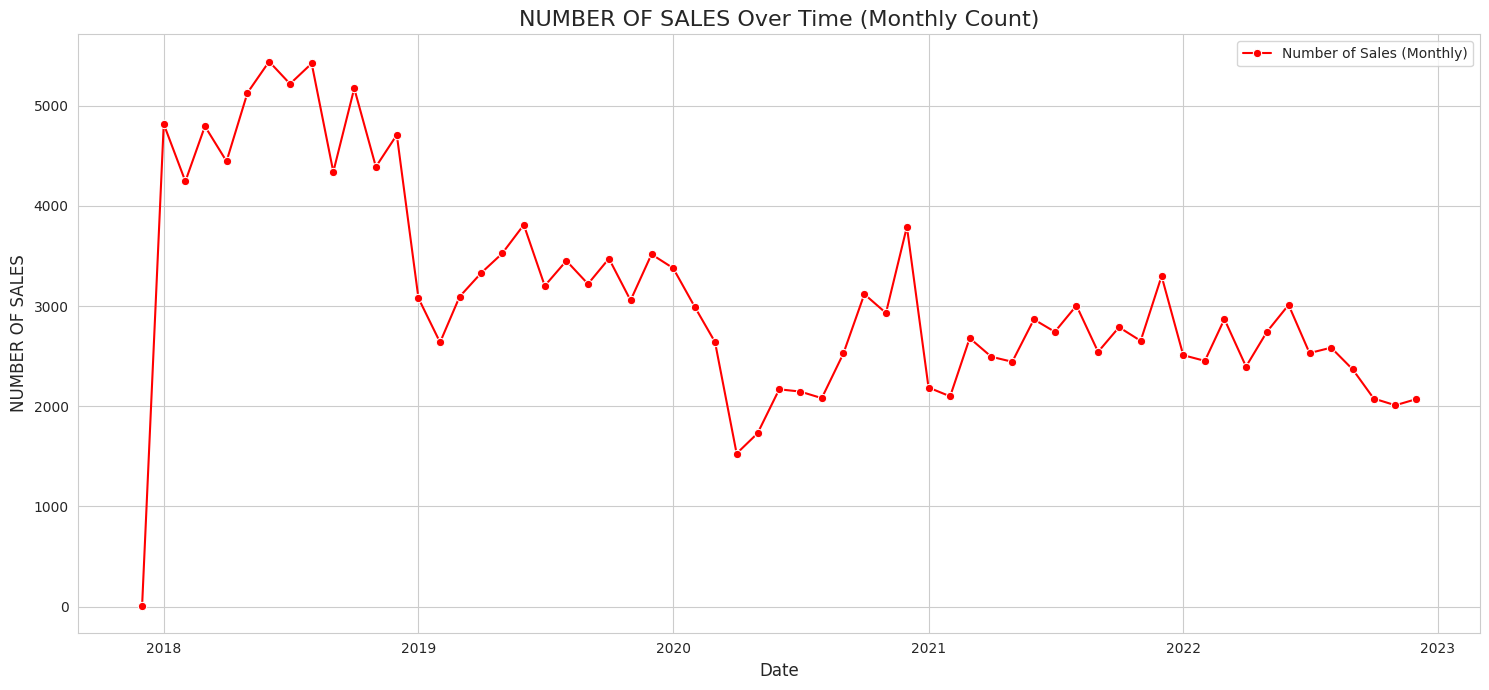

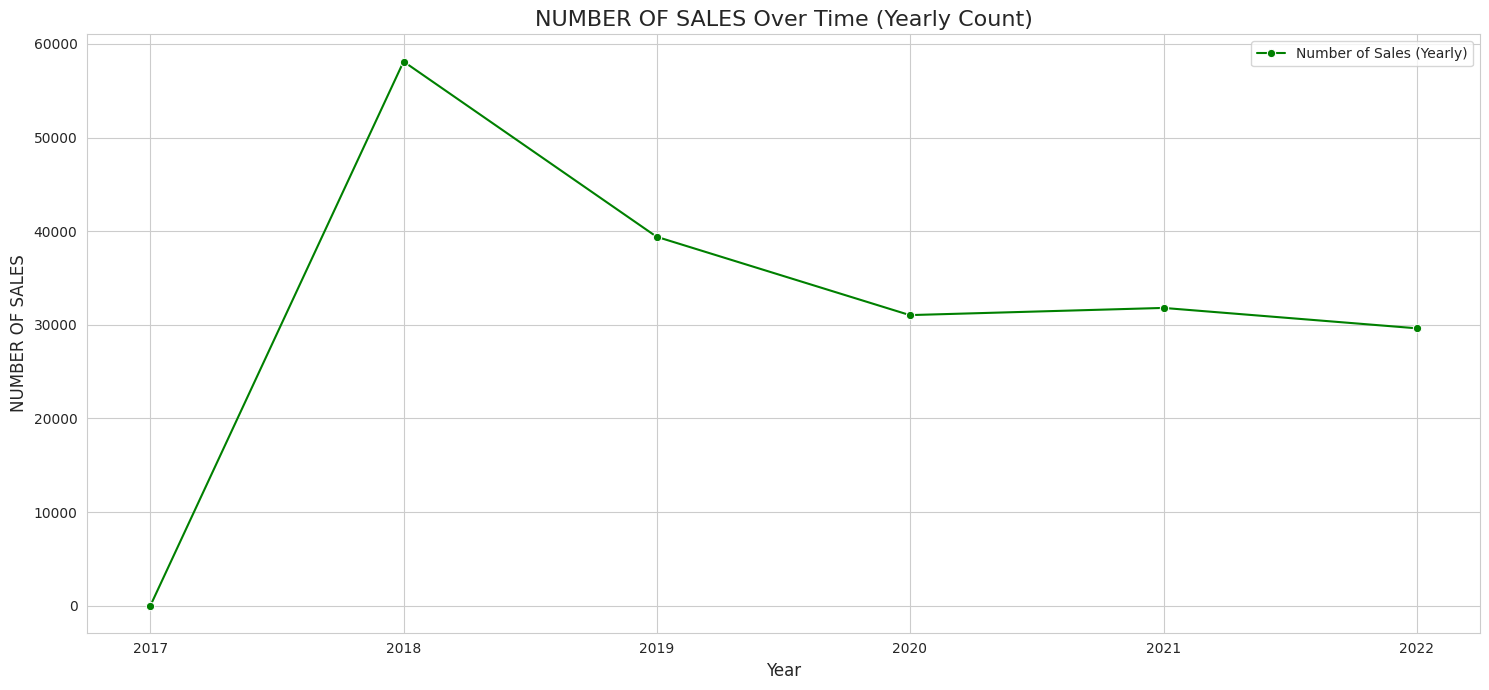

In [ ]:
# 1. Extract the year and month from the 'SALE DATE' column
df_cleaned['Sale_Year'] = df_cleaned['SALE DATE'].dt.year
df_cleaned['Sale_Month'] = df_cleaned['SALE DATE'].dt.month

# 4. Calculate the count of sales for each group to represent 'NUMBER OF SALES' (Monthly Count)
num_sales_over_time = df_cleaned.groupby(['Sale_Year', 'Sale_Month']).size().reset_index(name='NUMBER OF SALES')
num_sales_over_time['Sale_Date_Monthly'] = pd.to_datetime(num_sales_over_time['Sale_Year'].astype(str) + '-' + num_sales_over_time['Sale_Month'].astype(str))

# Calculate Yearly Number of Sales
yearly_num_sales_over_time = df_cleaned.groupby('Sale_Year').size().reset_index(name='NUMBER OF SALES')
yearly_num_sales_over_time['Sale_Date_Yearly'] = pd.to_datetime(yearly_num_sales_over_time['Sale_Year'].astype(str) + '-01-01')

# Set up the plotting style
sns.set_style("whitegrid")

# Plot 1: NUMBER OF SALES Over Time (Monthly Count)
plt.figure(figsize=(15, 7))
sns.lineplot(data=num_sales_over_time, x='Sale_Date_Monthly', y='NUMBER OF SALES', marker='o', color='red', label='Number of Sales (Monthly)')
plt.title('NUMBER OF SALES Over Time (Monthly Count)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('NUMBER OF SALES', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: NUMBER OF SALES Over Time (Yearly Count)
plt.figure(figsize=(15, 7))
sns.lineplot(data=yearly_num_sales_over_time, x='Sale_Date_Yearly', y='NUMBER OF SALES', marker='o', color='green', label='Number of Sales (Yearly)')
plt.title('NUMBER OF SALES Over Time (Yearly Count)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('NUMBER OF SALES', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Feature Correlation with Sale Price

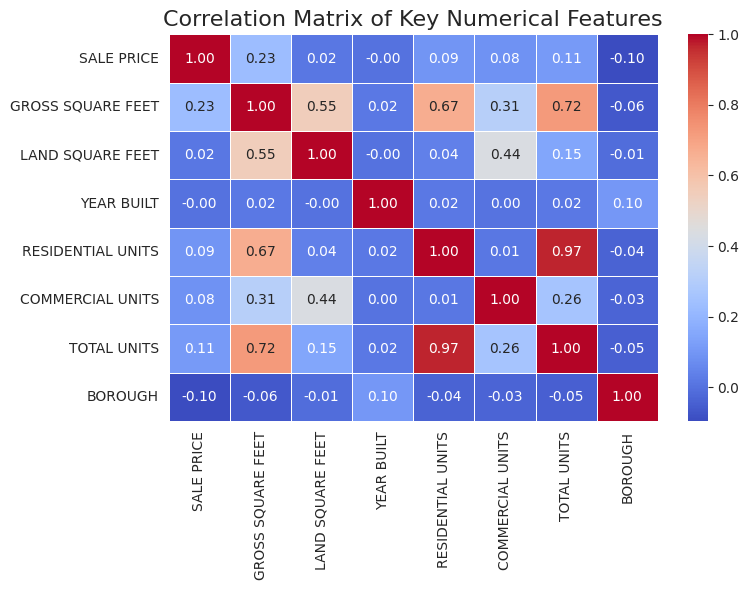

In [43]:
# 1. Select the relevant numerical columns
numerical_cols_for_corr = [
    'SALE PRICE',
    'GROSS SQUARE FEET',
    'LAND SQUARE FEET',
    'YEAR BUILT',
    'RESIDENTIAL UNITS',
    'COMMERCIAL UNITS',
    'TOTAL UNITS',
    'BOROUGH' # BOROUGH is also numerical now
]

# Ensure all selected columns exist in the DataFrame
numerical_cols_for_corr = [col for col in numerical_cols_for_corr if col in df_cleaned.columns]

df_numerical = df_cleaned[numerical_cols_for_corr].copy()

# 2. Calculate the Pearson correlation matrix
correlation_matrix = df_numerical.corr()

# 3. Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))

sns.heatmap(
    correlation_matrix,
    annot=True, # Show the correlation values on the heatmap
    cmap='coolwarm', # Choose a diverging colormap
    fmt=".2f", # Format annotation to two decimal places
    linewidths=.5 # Add lines between cells
)

# 5. Add a title to the heatmap
plt.title('Correlation Matrix of Key Numerical Features', fontsize=16)

# 6. Display the plot
plt.tight_layout()
plt.show()

## Feature Engineering

In [ ]:
df_fe = df_cleaned.copy()

# 1. Calculate 'PRICE_PER_SQFT'
# Replace 0 in 'GROSS SQUARE FEET' with NaN to avoid division by zero
df_fe['GROSS SQUARE FEET'] = df_fe['GROSS SQUARE FEET'].replace(0, np.nan)
df_fe['PRICE_PER_SQFT'] = df_fe['SALE PRICE'] / df_fe['GROSS SQUARE FEET']
# Fill resulting NaN values (e.g., where GROSS SQUARE FEET was originally 0 or NaN) with 0.
df_fe['PRICE_PER_SQFT'] = df_fe['PRICE_PER_SQFT'].fillna(0)

# 2. Create 'AGE_OF_BUILDING'
df_fe['AGE_OF_BUILDING'] = df_fe['Sale_Year'] - df_fe['YEAR BUILT']

# 3. Address unrealistic 'AGE_OF_BUILDING' values
# Set AGE_OF_BUILDING to 0 where YEAR BUILT is 0
df_fe.loc[df_fe['YEAR BUILT'] == 0, 'AGE_OF_BUILDING'] = 0
# Set AGE_OF_BUILDING to 0 for any properties where YEAR BUILT is greater than Sale_Year
df_fe.loc[df_fe['YEAR BUILT'] > df_fe['Sale_Year'], 'AGE_OF_BUILDING'] = 0

print("New features 'PRICE_PER_SQFT' and 'AGE_OF_BUILDING' created and cleaned.")

# Define a mapping for borough numbers to names for one-hot encoding
borough_names = {
    1: 'Manhattan',
    2: 'Bronx',
    3: 'Brooklyn',
    4: 'Queens',
    5: 'Staten Island'
}

# Create a new column with borough names as strings for one-hot encoding
df_fe['BOROUGH_NAME'] = df_fe['BOROUGH'].map(borough_names)

# Explicitly convert relevant columns to string/object type to ensure pd.get_dummies processes them
df_fe['TAX CLASS AT TIME OF SALE'] = df_fe['TAX CLASS AT TIME OF SALE'].astype(str)
df_fe['BUILDING CLASS CATEGORY'] = df_fe['BUILDING CLASS CATEGORY'].astype(str)
# Convert ZIP CODE to string type and handle NaNs for one-hot encoding
df_fe['ZIP CODE'] = df_fe['ZIP CODE'].fillna(-1).astype(int).astype(str)

# 5. Apply one-hot encoding to all identified categorical features
categorical_features_to_encode = [
    'BOROUGH_NAME',
    'TAX CLASS AT TIME OF SALE',
    'BUILDING CLASS CATEGORY',
    'ZIP CODE'
]

# Ensure all columns exist before encoding
categorical_features_to_encode = [col for col in categorical_features_to_encode if col in df_fe.columns]

df_fe = pd.get_dummies(df_fe, columns=categorical_features_to_encode, drop_first=True, dtype=int)

# Drop the original numerical 'BOROUGH' column after its named one-hot encoded counterpart exists
df_fe.drop(columns=['BOROUGH'], inplace=True)

print("Categorical features one-hot encoded.")

df_fe.info()

New features 'PRICE_PER_SQFT' and 'AGE_OF_BUILDING' created and cleaned.
Categorical features one-hot encoded.
<class 'pandas.core.frame.DataFrame'>
Index: 190001 entries, 0 to 515807
Columns: 273 entries, NEIGHBORHOOD to ZIP CODE_11697
dtypes: datetime64[ns](1), float64(9), int32(2), int64(255), object(6)
memory usage: 395.7+ MB


## Prepare Data for Modeling

In [ ]:
# 1. Define the target variable y as 'SALE PRICE'
y = df_fe['SALE PRICE']

# 2. Create the feature set X by dropping specified columns
columns_to_drop = [
    'SALE PRICE',
    'NEIGHBORHOOD',
    'ADDRESS',
    'APARTMENT NUMBER',
    'TAX CLASS AT PRESENT',
    'BUILDING CLASS AT PRESENT',
    'BUILDING CLASS AT TIME OF SALE',
    'SALE DATE'
]

# Ensure only existing columns are dropped
existing_cols_to_drop = [col for col in columns_to_drop if col in df_fe.columns]
X = df_fe.drop(columns=existing_cols_to_drop, axis=1)

# 3. Check for any remaining missing values in the X DataFrame and drop rows containing them
initial_X_rows = X.shape[0]
if X.isnull().sum().sum() > 0:
    X.dropna(inplace=True)
    print(f"Dropped {initial_X_rows - X.shape[0]} rows with missing values in X. Remaining rows: {X.shape[0]}")
else:
    print("No missing values found in X.")

# Align y with X after dropping rows
y = y.loc[X.index]

# 4. Split the X and y data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Identify the numerical columns in X_train that are not one-hot encoded
# One-hot encoded columns will now start with these prefixes.
# We want to exclude these from scaling as they are already 0/1 binary features.

one_hot_prefix = [
    'BOROUGH_NAME_',
    'TAX CLASS AT TIME OF SALE_',
    'BUILDING CLASS CATEGORY_',
    'ZIP CODE_'
]

# Identify numerical columns that are not one-hot encoded by checking prefixes
numerical_cols_for_scaling = [col for col in X_train.select_dtypes(include=['number']).columns if
                                  not any(col.startswith(prefix) for prefix in one_hot_prefix)]

# Add other numerical columns that might not be caught by prefix but are numerical
newly_created_numerical = ['AGE_OF_BUILDING', 'PRICE_PER_SQFT', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'BLOCK', 'LOT', 'Sale_Year', 'Sale_Month']
for col in newly_created_numerical:
    if col in X_train.columns and col not in numerical_cols_for_scaling and X_train[col].dtype != 'object' and not any(col.startswith(prefix) for prefix in one_hot_prefix):
        numerical_cols_for_scaling.append(col)

print(f"Numerical columns identified for scaling: {numerical_cols_for_scaling}")

# 6. Initialize a StandardScaler
scaler = StandardScaler()

# 7. Fit the StandardScaler to the numerical columns of X_train and transform both X_train and X_test
X_train[numerical_cols_for_scaling] = scaler.fit_transform(X_train[numerical_cols_for_scaling])
X_test[numerical_cols_for_scaling] = scaler.transform(X_test[numerical_cols_for_scaling])

print("Numerical features scaled.")

# 8. Print the shapes of X_train, X_test, y_train, and y_test
print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Dropped 36778 rows with missing values in X. Remaining rows: 153223
Numerical columns identified for scaling: ['BLOCK', 'LOT', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'Sale_Year', 'Sale_Month', 'PRICE_PER_SQFT', 'AGE_OF_BUILDING']
Numerical features scaled.

Shape of X_train: (122578, 265)
Shape of X_test: (30645, 265)
Shape of y_train: (122578,)
Shape of y_test: (30645,)


## Train and Evaluate Linear Regression Model

Linear Regression Model Performance:
R-squared: 0.2197
Mean Absolute Error (MAE): 1906387.94
Root Mean Squared Error (RMSE): 15454825.38


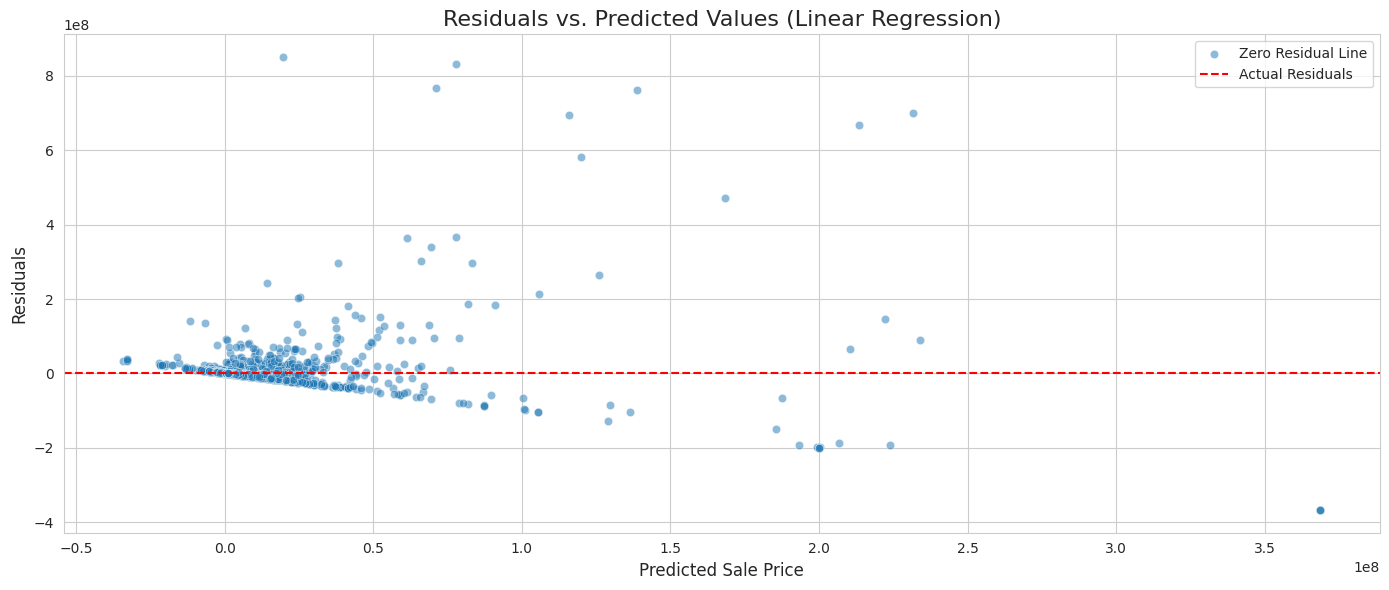

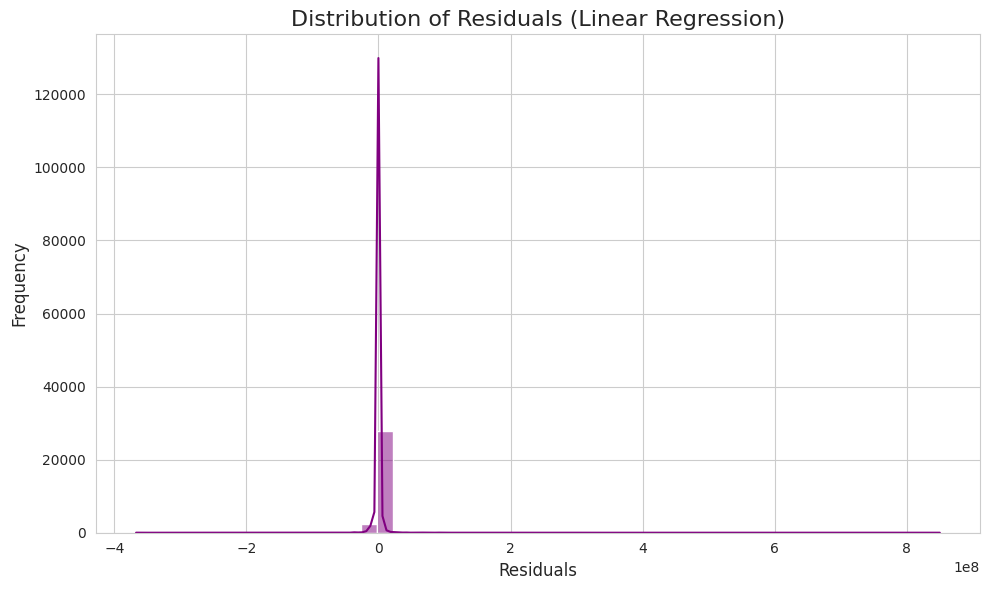

In [ ]:
# 1. Instantiate a LinearRegression model object
linear_model = LinearRegression()

# 2. Fit the LinearRegression model to the training data
linear_model.fit(X_train, y_train)

# 3. Make predictions on the test data
y_pred_lr = linear_model.predict(X_test)

# 4. Calculate evaluation metrics
r2 = r2_score(y_test, y_pred_lr)
mae = mean_absolute_error(y_test, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# 5. Print the calculated metrics
print(f"Linear Regression Model Performance:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# -------------------------------
# VISUALIZATIONS FOR Linear Regression Residuals Analysis
# -------------------------------

# Calculate residuals for Linear Regression (as existing)
residuals_lr = y_test - y_pred_lr

sns.set_style("whitegrid")

# Plot 1: Residuals vs. Predicted Values (Linear Regression)
plt.figure(figsize=(14, 6))
sns.scatterplot(x=y_pred_lr, y=residuals_lr, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values (Linear Regression)', fontsize=16)
plt.xlabel('Predicted Sale Price', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.legend(['Zero Residual Line', 'Actual Residuals'], loc='upper right')
plt.tight_layout()
plt.show()

# Plot 2: Histogram of Residuals (Linear Regression)
plt.figure(figsize=(10, 6))
sns.histplot(residuals_lr, bins=50, kde=True, color='purple')
plt.title('Distribution of Residuals (Linear Regression)', fontsize=16)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

## Train and Evaluate Decision Tree Models

Training Base Decision Tree Model...

--- Base Decision Tree Performance ---
MAE: 263107.59
MSE: 178498289679926.94
RMSE: 13360325.21
R2 Score: 0.42

Performing Hyperparameter Tuning for Decision Tree using RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Decision Tree Parameters: {'min_samples_split': 20, 'min_samples_leaf': 4, 'max_depth': 20}
Best CV MSE: 41804244105607.98

--- Tuned Decision Tree (RandomizedSearchCV) Performance ---
MAE: 206795.25
MSE: 28254365931648.92
RMSE: 5315483.60
R2 Score: 0.91

Generating Overfitting vs. Underfitting plot...


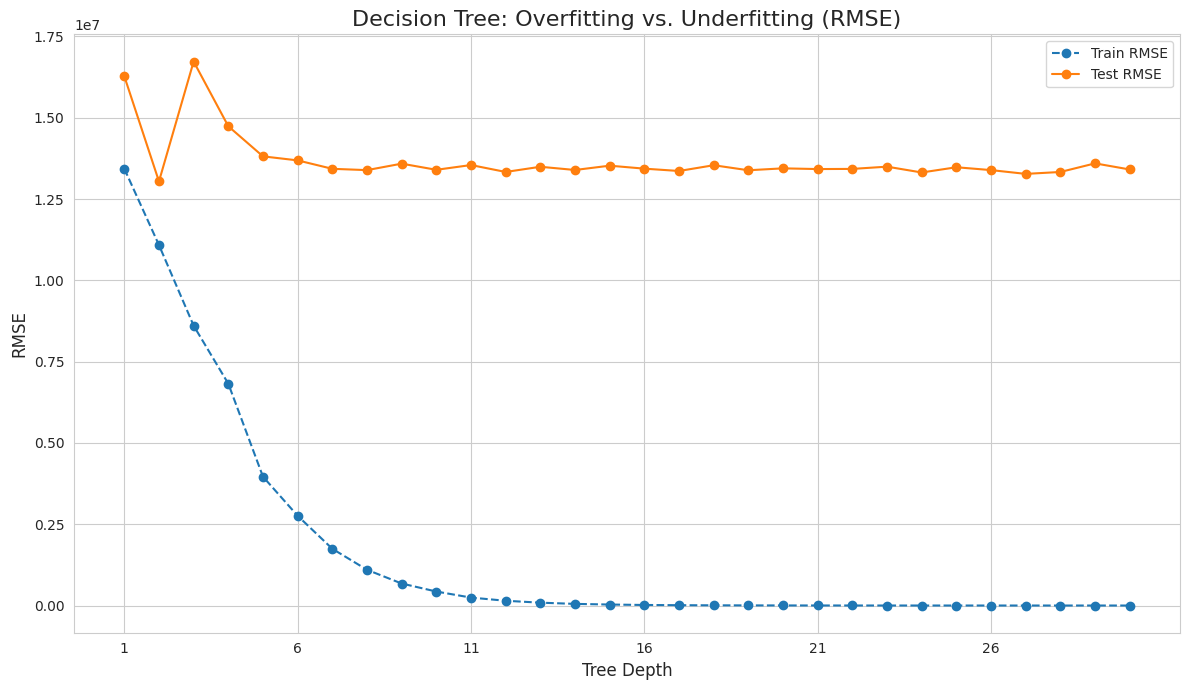


Generating Residuals Plots for Tuned Decision Tree...


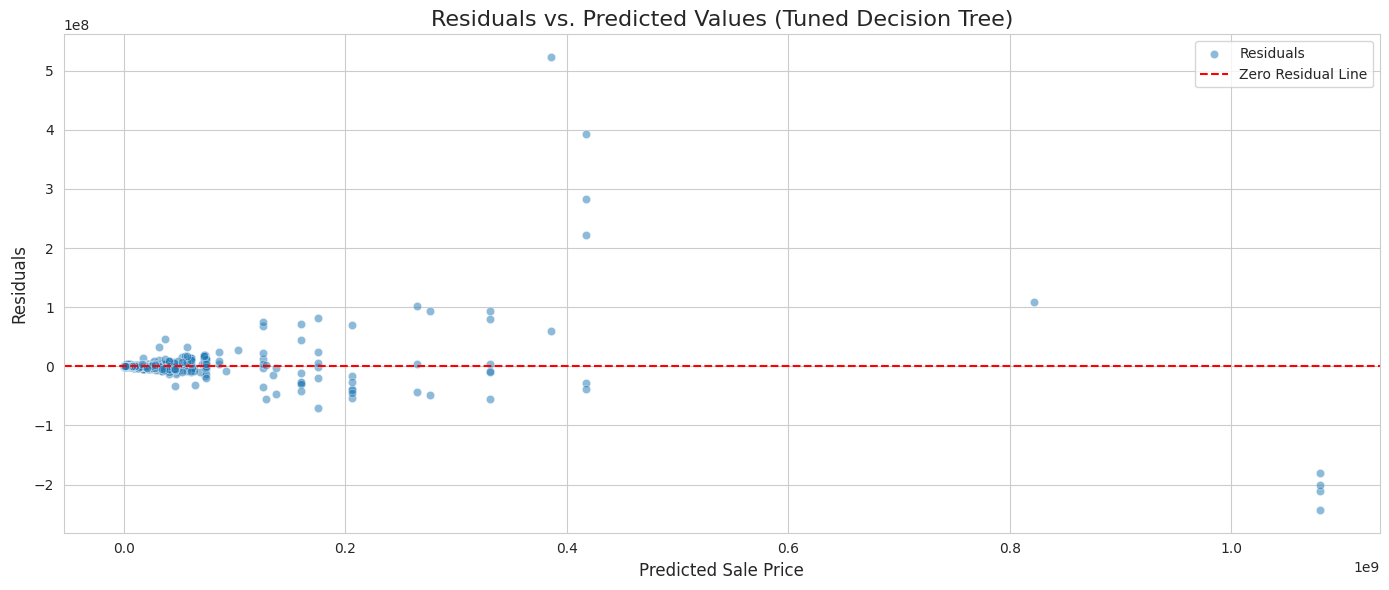

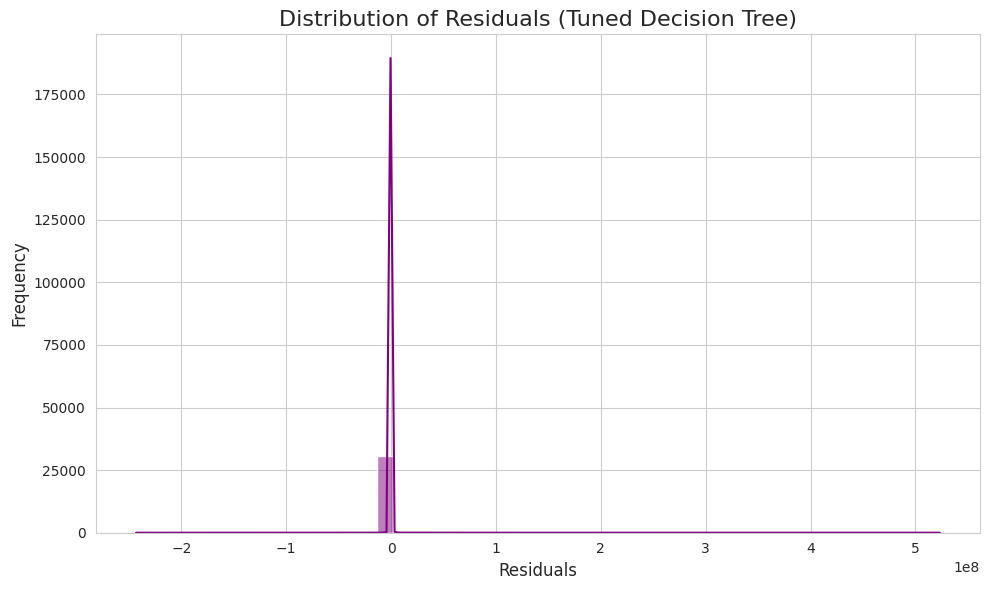


--- Summary of Decision Tree Models in current run ---

Base Decision Tree:
  MAE: 263107.59
  MSE: 178498289679926.94
  RMSE: 13360325.21
  R2: 0.42

Tuned Decision Tree (RandomizedSearchCV):
  MAE: 206795.25
  MSE: 28254365931648.92
  RMSE: 5315483.60
  R2: 0.91


In [ ]:
# Store model results for later comparison across different models
# This dictionary will be populated with metrics from the Decision Tree models in this cell.
if 'all_model_results' not in locals():
    all_model_results = {}

# -------------------------------
# EVALUATION FUNCTION (Modified to include RMSE and return metrics)
# -------------------------------
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n--- {name} Performance ---")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")

    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

# -------------------------------
# BASE DECISION TREE MODEL TRAINING AND EVALUATION
# -------------------------------
print("Training Base Decision Tree Model...")
dt_base = DecisionTreeRegressor(random_state=42)
dt_base.fit(X_train, y_train)

y_pred_dt_base = dt_base.predict(X_test)
base_dt_metrics = evaluate_model('Base Decision Tree', y_test, y_pred_dt_base)
all_model_results['Base Decision Tree'] = base_dt_metrics


# -------------------------------
# HYPERPARAMETER TUNING FOR DECISION TREE (Using RandomizedSearchCV)
# -------------------------------
print("\nPerforming Hyperparameter Tuning for Decision Tree using RandomizedSearchCV...")

from sklearn.model_selection import RandomizedSearchCV

param_dist_dt = {
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4, 8]
}

# RandomizedSearchCV samples a fixed number of parameter settings
random_search_dt = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_distributions=param_dist_dt,
    n_iter=20,  # Number of random combinations tested
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit the randomized search model
random_search_dt.fit(X_train, y_train)

# Best estimator after tuning
best_dt = random_search_dt.best_estimator_

# Predictions using tuned model
y_pred_best_dt = best_dt.predict(X_test)

# Evaluation
print("\nBest Decision Tree Parameters:", random_search_dt.best_params_)
print("Best CV MSE:", -random_search_dt.best_score_)

tuned_dt_metrics = evaluate_model("Tuned Decision Tree (RandomizedSearchCV)", y_test, y_pred_best_dt)
all_model_results['Tuned Decision Tree (RandomizedSearchCV)'] = tuned_dt_metrics

# -------------------------------
# OVERFITTING / UNDERFITTING VISUALIZATION (Improved with RMSE)
# -------------------------------

# Plot 1: Overfitting vs. Underfitting plot
print("\nGenerating Overfitting vs. Underfitting plot...")
train_errors_mse = []
test_errors_mse = []

# Use a reasonable range for max_depth, perhaps slightly beyond the best found
depths = range(1, 31) # Extended range for better visualization
for d in depths:
    model = DecisionTreeRegressor(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    train_errors_mse.append(mean_squared_error(y_train, model.predict(X_train)))
    test_errors_mse.append(mean_squared_error(y_test, model.predict(X_test)))

plt.figure(figsize=(12, 7))
plt.plot(depths, np.sqrt(train_errors_mse), label='Train RMSE', marker='o', linestyle='--')
plt.plot(depths, np.sqrt(test_errors_mse), label='Test RMSE', marker='o')
plt.xlabel('Tree Depth', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Decision Tree: Overfitting vs. Underfitting (RMSE)', fontsize=16)
plt.xticks(np.arange(min(depths), max(depths)+1, 5)) # Adjust x-ticks for readability
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# RESIDUALS PLOTS FOR TUNED DECISION TREE
# -------------------------------

# Plot 2: Residuals Plots

print("\nGenerating Residuals Plots for Tuned Decision Tree...")

residuals_tuned_dt = y_test - y_pred_best_dt

sns.set_style("whitegrid")

plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=y_pred_best_dt,
    y=residuals_tuned_dt,
    alpha=0.5,
    label='Residuals'
)

plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual Line')

plt.title('Residuals vs. Predicted Values (Tuned Decision Tree)', fontsize=16)
plt.xlabel('Predicted Sale Price', fontsize=12)
plt.ylabel('Residuals', fontsize=12)

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


# Plot 3: Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals_tuned_dt, bins=50, kde=True, color='purple')
plt.title('Distribution of Residuals (Tuned Decision Tree)', fontsize=16)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

# Final output for Decision Tree model summary (structured model comparison preparation)
print("\n--- Summary of Decision Tree Models in current run ---")
for model_name, metrics in all_model_results.items():
    if "Decision Tree" in model_name: # Only print DT models here
        print(f"\n{model_name}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.2f}")

## Train and Evaluate Random Forest Regressor Model


Training Random Forest Regressor...

--- Random Forest Performance ---
MAE: 89364.35
MSE: 8638231772321.17
RMSE: 2939086.89
R2 Score: 0.97

--- Summary for Random Forest ---
  MAE: 89364.35
  MSE: 8638231772321.17
  RMSE: 2939086.89
  R2: 0.97


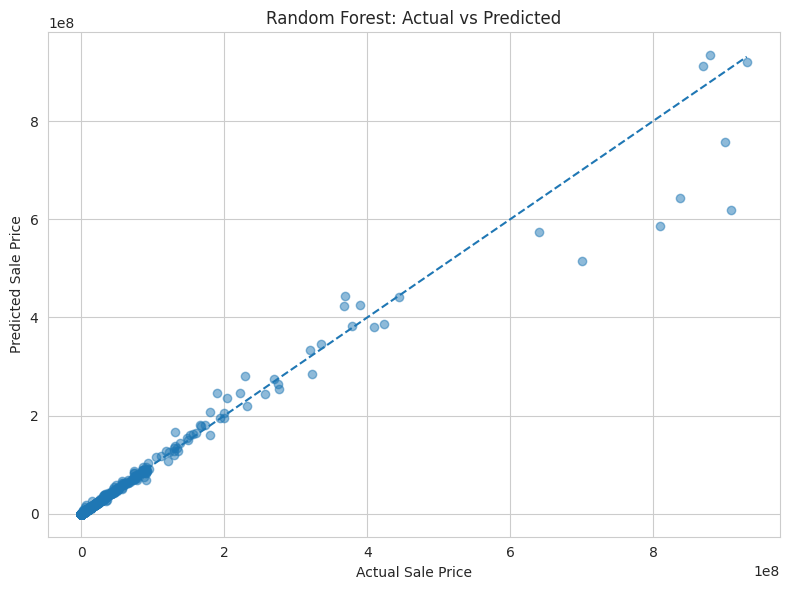

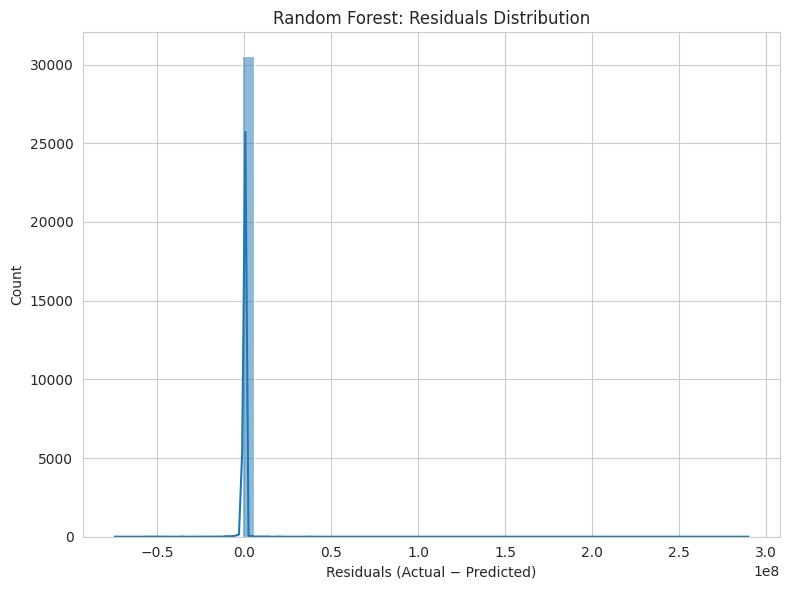

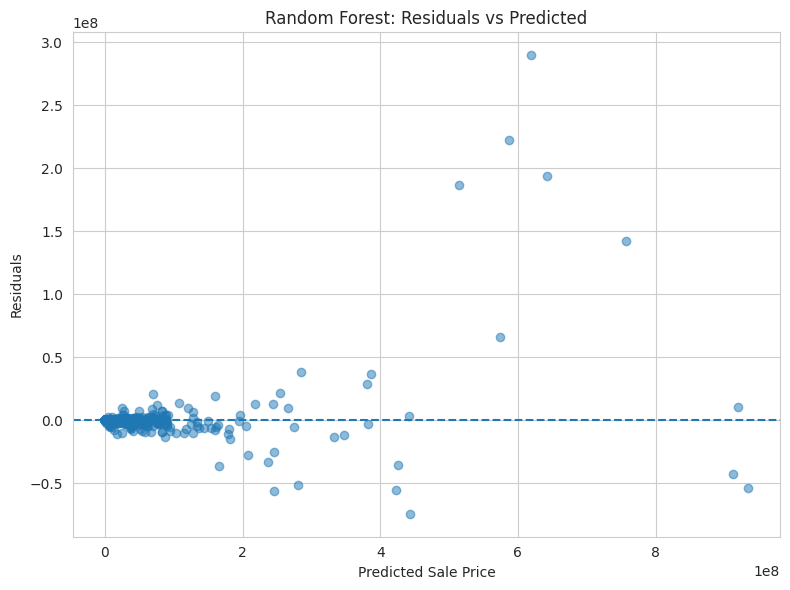

In [ ]:
print("\nTraining Random Forest Regressor...")
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

# -------------------------------
# MODEL EVALUATION For Random Forest
# -------------------------------
rf_metrics = evaluate_model('Random Forest', y_test, y_pred_rf)

if 'all_model_results' not in locals():
    all_model_results = {}

all_model_results['Random Forest'] = rf_metrics

print("\n--- Summary for Random Forest ---")
for metric, value in rf_metrics.items():
    print(f"  {metric}: {value:.2f}")

# -------------------------------
# VISUALIZATIONS FOR Random Forest
# -------------------------------

sns.set_style("whitegrid")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--')
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Random Forest: Actual vs Predicted")
plt.tight_layout()
plt.show()

residuals_rf = y_test - y_pred_rf

plt.figure(figsize=(8, 6))
sns.histplot(residuals_rf, bins=50, kde=True)
plt.xlabel("Residuals (Actual − Predicted)")
plt.title("Random Forest: Residuals Distribution")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_rf, residuals_rf, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted Sale Price")
plt.ylabel("Residuals")
plt.title("Random Forest: Residuals vs Predicted")
plt.tight_layout()
plt.show()


## Train and Evaluate Gradient Boosting Regressor Model

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2365
[LightGBM] [Info] Number of data points in the train set: 122578, number of used features: 221
[LightGBM] [Info] Start training from score 1891836.332392

--- Gradient Boosting Regressor Performance ---
MAE: 386675.37
MSE: 40739177680422.03
RMSE: 6382724.94
R2 Score: 0.87


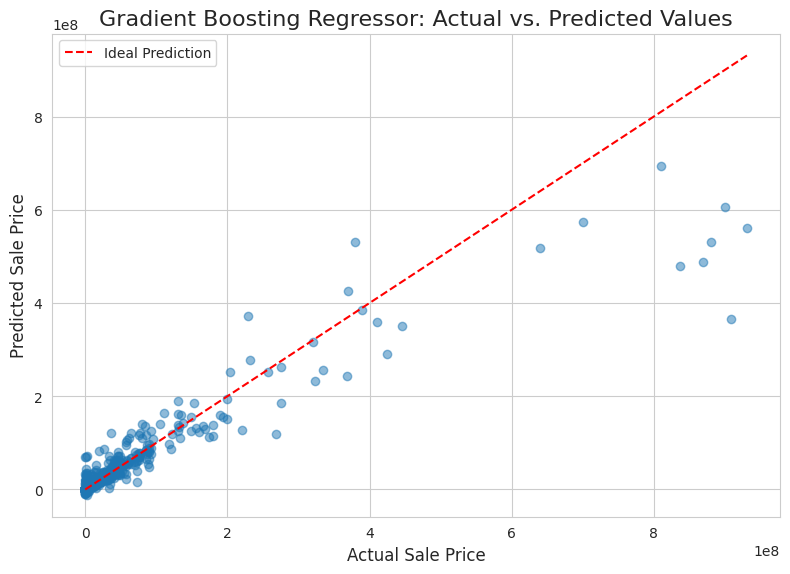

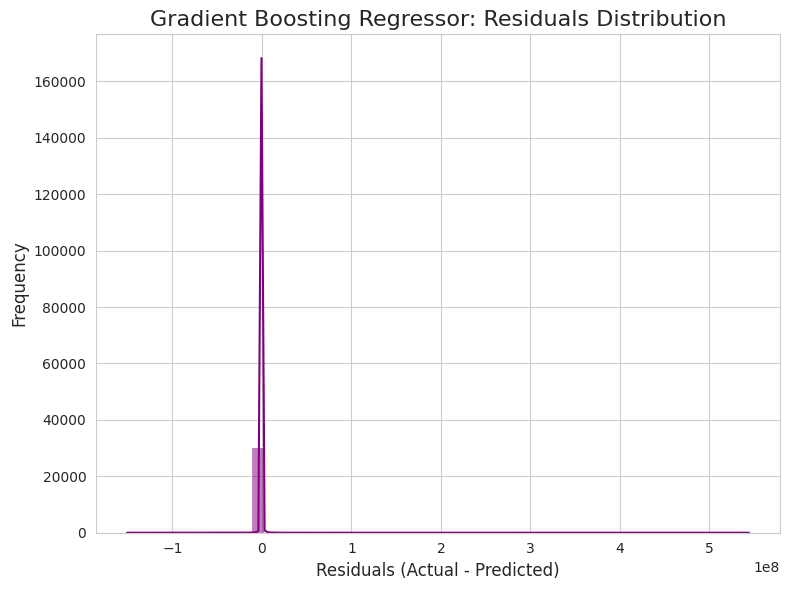

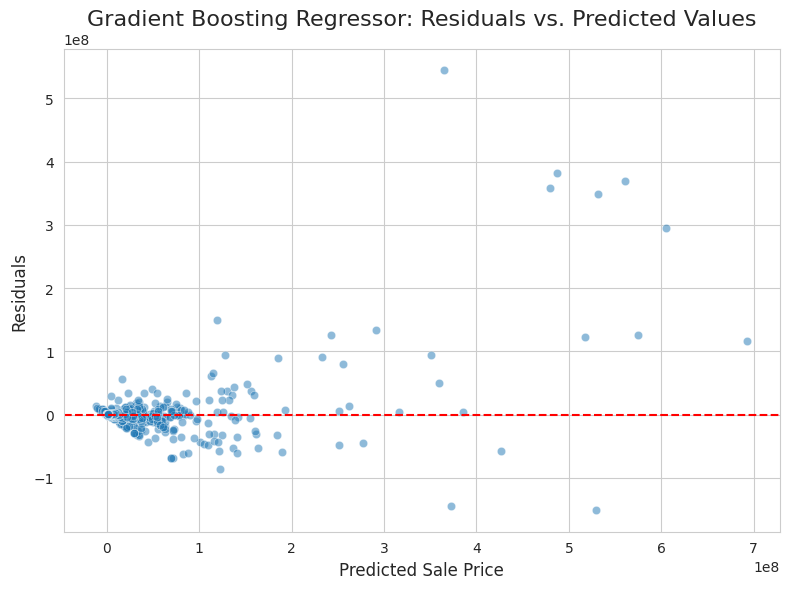

In [ ]:
# 1. Instantiate an LGBMRegressor model object
lgbm_model = LGBMRegressor(random_state=42)

# 2. Fit the LGBMRegressor model to the training data
lgbm_model.fit(X_train, y_train)

# 3. Make predictions on the test data
y_pred_gb = lgbm_model.predict(X_test)

# 4. Calculate evaluation metrics using the evaluate_model function
# Ensure evaluate_model is defined in an earlier cell or included here for robustness
# Assuming evaluate_model is globally defined by cell kHvOq4N7E93g

lgbm_metrics = evaluate_model('Gradient Boosting Regressor', y_test, y_pred_gb)

# Store results in the all_model_results dictionary
if 'all_model_results' not in locals():
    all_model_results = {}
all_model_results['Gradient Boosting Regressor'] = lgbm_metrics

# -------------------------------
# VISUALIZATIONS FOR LGBM REGRESSOR
# -------------------------------
sns.set_style("whitegrid")

# Plot 1: Actual vs. Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--', color='red', label='Ideal Prediction')
plt.xlabel("Actual Sale Price", fontsize=12)
plt.ylabel("Predicted Sale Price", fontsize=12)
plt.title("Gradient Boosting Regressor: Actual vs. Predicted Values", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

residuals_gb = y_test - y_pred_gb

# Plot 2: Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals_gb, bins=50, kde=True, color='purple')
plt.xlabel("Residuals (Actual - Predicted)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Gradient Boosting Regressor: Residuals Distribution", fontsize=16)
plt.tight_layout()
plt.show()

# Plot 3: Residuals vs. Predicted Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_gb, y=residuals_gb, alpha=0.5)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicted Sale Price", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.title("Gradient Boosting Regressor: Residuals vs. Predicted Values", fontsize=16)
plt.tight_layout()
plt.show()

## Model Comparison and Summary


Model Comparison (R2 Score):
                                      Model  R2 Score
2                             Random Forest  0.971781
1  Tuned Decision Tree (RandomizedSearchCV)  0.907699
3               Gradient Boosting Regressor  0.866914
0                        Base Decision Tree  0.416887
4                         Linear Regression  0.219726

Model Comparison (RMSE):
                                      Model          RMSE
2                             Random Forest  2.939087e+06
1  Tuned Decision Tree (RandomizedSearchCV)  5.315484e+06
3               Gradient Boosting Regressor  6.382725e+06
0                        Base Decision Tree  1.336033e+07
4                         Linear Regression  1.545483e+07


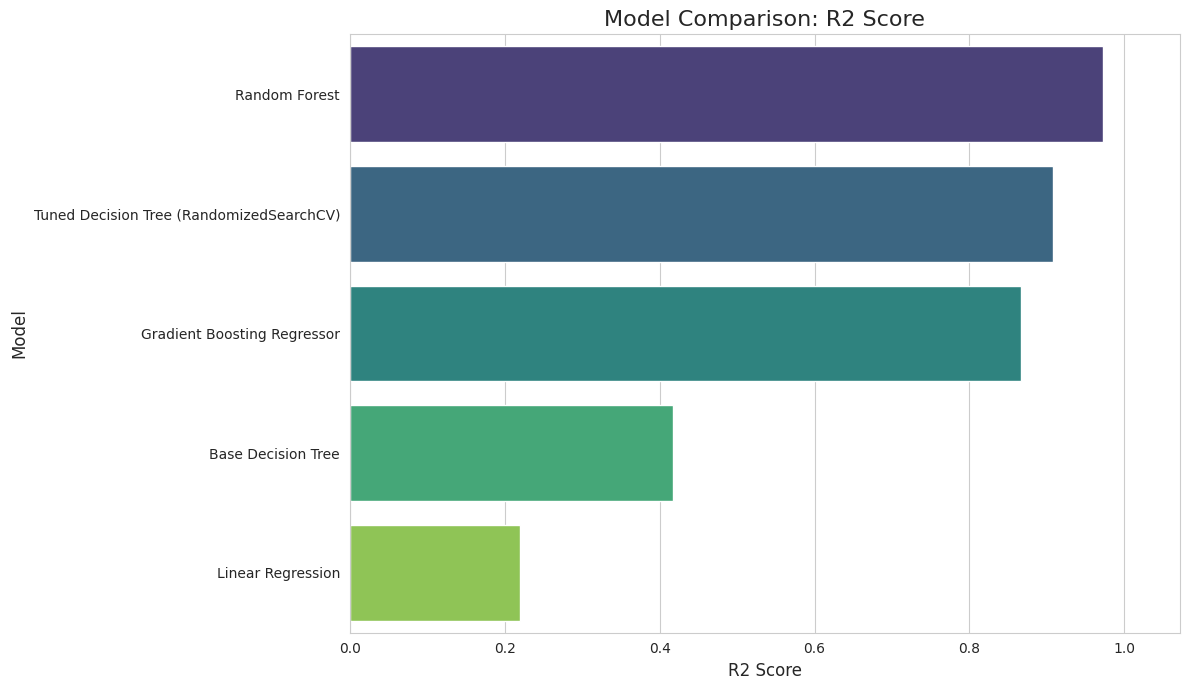

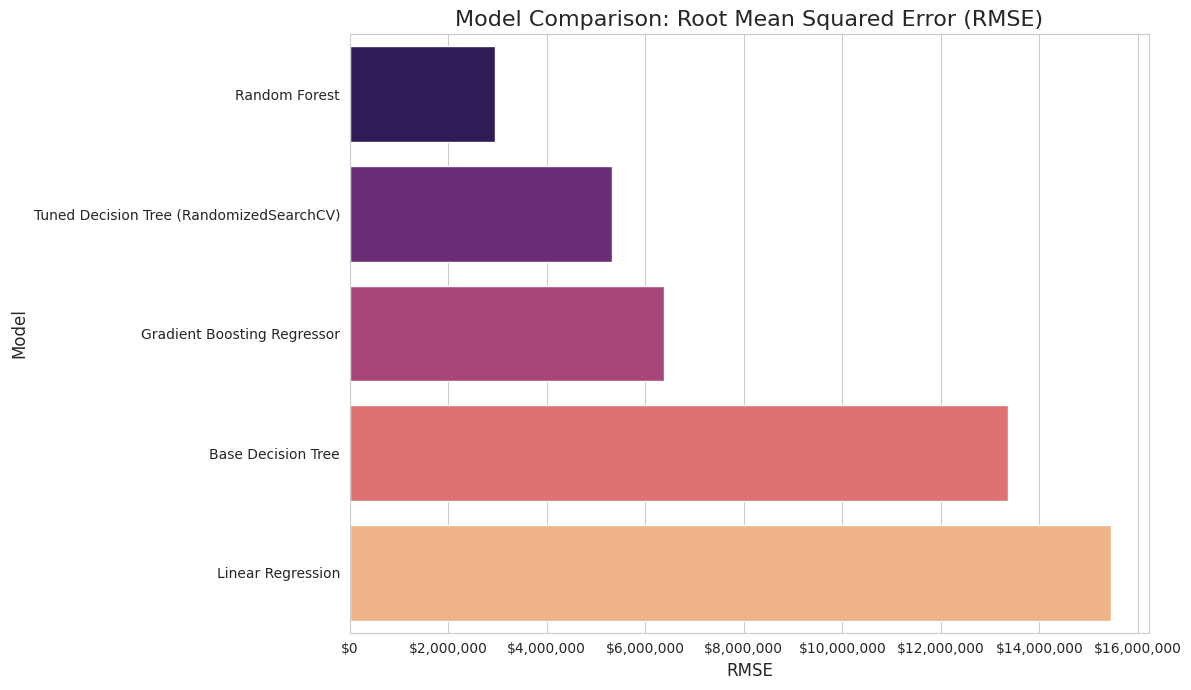

In [44]:
# -------------------------------
# FINAL MODEL COMPARISON SUMMARY
# -------------------------------

# Ensure all_model_results is defined, even if previous cells were skipped
if 'all_model_results' not in locals():
    all_model_results = {}

# Extract model names, R2, and RMSE scores from the collected results
model_names = []
r2_scores = []
rmse_scores = []

for model_name, metrics in all_model_results.items():
    model_names.append(model_name)
    r2_scores.append(metrics.get('R2'))
    rmse_scores.append(metrics.get('RMSE'))

# Special handling for Linear Regression if not already in all_model_results
if 'r2' in globals() and 'Linear Regression' not in model_names:
    model_names.append('Linear Regression')
    r2_scores.append(r2)
    # Try to get rmse for LR if defined globally, else use np.nan
    rmse_scores.append(globals().get('rmse', np.nan)) # Assuming 'rmse' is a global var for LR

# Create DataFrame for R2 Scores
results_r2 = pd.DataFrame({
    'Model': model_names,
    'R2 Score': r2_scores
})
# Sort R2 results for better visualization
results_r2 = results_r2.sort_values(by='R2 Score', ascending=False)

print("\nModel Comparison (R2 Score):")
print(results_r2)

# Create DataFrame for RMSE Scores
results_rmse = pd.DataFrame({
    'Model': model_names,
    'RMSE': rmse_scores
})
# Sort RMSE results (lower is better) for better visualization, handling NaNs
results_rmse = results_rmse.sort_values(by='RMSE', ascending=True)

print("\nModel Comparison (RMSE):")
print(results_rmse)

# -------------------------------
# VISUALIZATION: BAR PLOT OF R2 SCORES
# -------------------------------
plt.figure(figsize=(12, 7))
sns.barplot(x='R2 Score', y='Model', data=results_r2, palette='viridis', hue='Model', legend=False)
plt.title('Model Comparison: R2 Score', fontsize=16)
plt.xlabel('R2 Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(min(0, results_r2['R2 Score'].min() - 0.1), results_r2['R2 Score'].max() + 0.1)
plt.tight_layout()
plt.show()

# -------------------------------
# VISUALIZATION: BAR PLOT OF RMSE SCORES
# -------------------------------
plt.figure(figsize=(12, 7))
sns.barplot(x='RMSE', y='Model', data=results_rmse, palette='magma', hue='Model', legend=False)
plt.title('Model Comparison: Root Mean Squared Error (RMSE)', fontsize=16)
plt.xlabel('RMSE', fontsize=12)
plt.ylabel('Model', fontsize=12)
# Adjust x-axis limits dynamically, ensuring lower values are better
max_rmse_val = results_rmse['RMSE'].max()
plt.xlim(0, max_rmse_val + (max_rmse_val * 0.05)) # Add a small buffer
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${int(x):,}')) # Format as currency
plt.tight_layout()
plt.show()

## Project Summary

This project aimed to analyze NYC property sales data, predict sales prices using machine learning models, and provide insights into the market. The analysis began by loading the `nyc-property-sales.csv` dataset, which contained over a million records.

**Data Loading and Preprocessing:**
- The initial dataset was filtered to include only sales from the last five years, reducing the dataset size significantly.
- Extensive data cleaning was performed, including stripping whitespace from column names, converting critical columns to numeric types, handling `NaT` values in 'SALE DATE', and removing records with a 'SALE PRICE' of 0. Rows with NaN values in critical numerical columns were also dropped, ensuring data quality for modeling.

**Exploratory Data Analysis (EDA):**
- **Borough Analysis:** Sales distribution and mean sale prices were analyzed across boroughs. Queens, Brooklyn, and Staten Island showed the highest number of sales, while Manhattan had the highest mean sale price, indicating its high-value properties.
- **Year Built:** The distribution of 'YEAR BUILT' highlighted the age profile of properties, with most built around the early 20th century.
- **Time Series Analysis:** Monthly and yearly sales counts revealed fluctuations and trends in property transactions over the observed period.
- **Feature Correlation:** A correlation matrix was generated for numerical features, showing 'GROSS SQUARE FEET', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', and 'TOTAL UNITS' had the strongest positive correlations with 'SALE PRICE'.

**Feature Engineering:**
- New features like 'PRICE_PER_SQFT' and 'AGE_OF_BUILDING' were created to capture more predictive power.
- Categorical features such as 'BOROUGH_NAME', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS CATEGORY', and 'ZIP CODE' were one-hot encoded to prepare them for machine learning models.

**Model Training and Evaluation:**
- The data was split into training and testing sets, and numerical features were scaled using `StandardScaler`.
- **Linear Regression:** A baseline Linear Regression model was trained, yielding an R-squared of 0.22 and an RMSE of $15,454,825.38.
- **Decision Tree Regressor:** Both a base Decision Tree model (R-squared: 0.42, RMSE: $13,360,325.21) and a hyperparameter-tuned version using `RandomizedSearchCV` (R-squared: 0.91, RMSE: $5,315,483.60) were developed.
- **Random Forest Regressor:** A Random Forest model was trained, achieving strong performance with an R-squared of 0.97 and an RMSE of $2,939,086.89.
- **Gradient Boosting Regressor (LGBMRegressor):** This model performed well, with an R-squared of 0.87 and an RMSE of $6,382,724.94.

**Model Comparison:**
- The Random Forest Regressor demonstrated the best performance among all models, with the highest R-squared and lowest RMSE, indicating superior predictive accuracy for NYC property sales prices. The Tuned Decision Tree also performed very well, outperforming Gradient Boosting in this particular scenario.

## Conclusion

This project successfully navigated through the stages of data loading, cleaning, EDA, feature engineering, and machine learning model development to predict NYC property sales prices. The comprehensive analysis provided valuable insights into the factors influencing property values in New York City.

**Key Findings:**
1.  **Data Quality is Crucial:** Thorough data cleaning, especially handling missing values and incorrect data types, was essential for building reliable models.
2.  **Borough-Specific Trends:** Significant disparities in sales volume and price were observed across different boroughs, underscoring the diverse nature of the NYC real estate market.
3.  **Impact of Property Characteristics:** Features like 'GROSS SQUARE FEET', 'TOTAL UNITS', and 'AGE_OF_BUILDING' were found to be strong predictors of 'SALE PRICE'.
4.  **Random Forest Superiority:** Among the tested models, the Random Forest Regressor emerged as the most effective, demonstrating a high R-squared (0.97) and the lowest RMSE ($2.94 million). This indicates its ability to capture complex non-linear relationships within the dataset effectively. The tuned Decision Tree also showed competitive performance.

**Recommendations:**
-   **Feature Importance Analysis:** Further investigation into the feature importances of the best-performing models (Random Forest) could provide deeper insights into which specific factors are driving property prices the most. This can inform real estate investment strategies or urban planning decisions.
-   **Advanced Feature Engineering:** Explore creating more sophisticated features, such as neighborhood-level average prices, proximity to public transport, or school ratings, to potentially enhance model accuracy.
-   **Time Series Specific Models:** For more detailed time-based predictions, integrating models that explicitly account for seasonality and trends (e.g., ARIMA, Prophet) could complement the current regression approaches.
-   **Outlier Treatment:** While some outliers were handled by removing $0 sale prices, a more nuanced approach to identify and treat extreme values (especially for `SALE PRICE` and `GROSS SQUARE FEET`) could further refine model performance.

Overall, the project provides a robust framework for predicting property sales in NYC, with the Random Forest model offering the most accurate predictions based on the current feature set. The insights gained can be valuable for various stakeholders in the real estate sector.